ResNet18, 34, 50, VIP, MVP, DINO

In [2]:
from pathlib import Path

from tqdm import trange
from sklearn.manifold import TSNE
import zarr

import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from r3m import load_r3m
import mvp
from vip import load_vip

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

Device: cuda


In [3]:
from src.models.encoders import models

**All Files Loading Info**


In [4]:
# NOTE: Change this to wherever the project is located in your google drive
project_root = Path("/home/ubuntu/semrep")
# project_root = Path("/content/drive/MyDrive/17 – Research/sim-2-real-representation-learning") # Lars
data_path = project_root / "data" / "processed"
models_path = project_root / "models"

In [4]:
# Load the data
sim1 = zarr.open(data_path / "one_leg_low_sim.zarr", mode="r")
sim2 = zarr.open(data_path / "one_leg_med_sim.zarr", mode="r")
real = zarr.open(data_path / "one_leg_low_real.zarr", mode="r")
sim1_imgs = sim1["color_image2"]
sim2_imgs = sim2["color_image2"]
real_imgs = real["color_image2"]
sim1_labels = sim1["action/pos"]
sim2_labels = sim2["action/pos"]
real_labels = real["action/pos"]


print(f"Loaded {len(sim1['episode_ends'])} trajectories containing {sim1_imgs.shape[0]} frames")
print(f"Loaded {len(sim2['episode_ends'])} trajectories containing {sim2_imgs.shape[0]} frames")
print(f"Loaded {len(real['episode_ends'])} trajectories containing {real_imgs.shape[0]} frames")

Loaded 50 trajectories containing 23371 frames
Loaded 25 trajectories containing 12263 frames
Loaded 50 trajectories containing 27699 frames


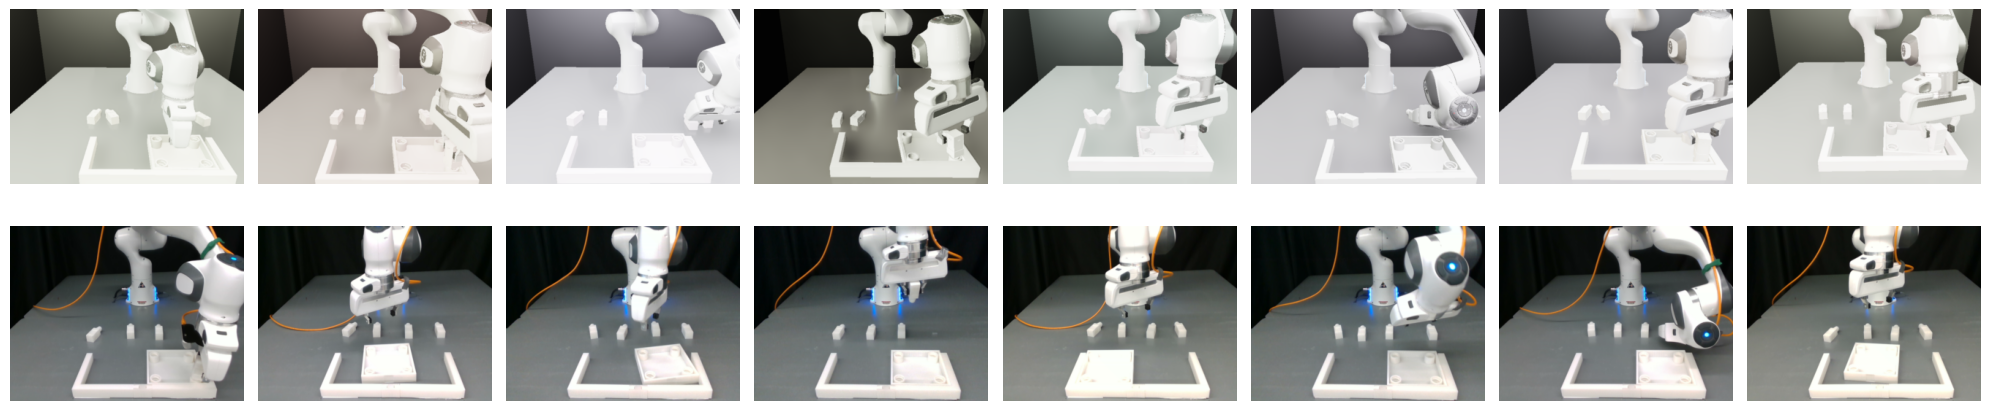

In [6]:
# Sample 8 images from each dataset
sim1_indices = np.random.choice(sim1_imgs.shape[0], size=8, replace=False)
sim2_indices = np.random.choice(sim2_imgs.shape[0], size=8, replace=False)
real_indices = np.random.choice(real_imgs.shape[0], size=8, replace=False)

# Create a figure and axes
fig, axes = plt.subplots(2, 8, figsize=(20, 5))

# # Display the sampled images
# for i, idx in enumerate(sim1_indices):
#     axes[0, i].imshow(sim1_imgs[idx])
#     axes[0, i].axis("off")

for i, idx in enumerate(sim2_indices):
    axes[1 - 1, i].imshow(sim2_imgs[idx])
    axes[1 - 1, i].axis("off")

for i, idx in enumerate(real_indices):
    axes[2 - 1, i].imshow(real_imgs[idx])
    axes[2 - 1, i].axis("off")

plt.tight_layout()
plt.show()

**Load Models**

In [5]:
# Choose the model to use
selected_model_name = "ResNet18"  # Change this to the desired model's name

# Load the selected model
model = models[selected_model_name]().cuda()

model.eval()

/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/r3m/__init__.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly

DataParallel(
  (module): R3M(
    (cs): CosineSimilarity()
    (bce): BCELoss()
    (sigm): Sigmoid()
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3

### Example of loading our own custom weights

I've trained some models on the data that we've visualized above (the real and the nicely rendered sets). Here, I'll show an example of how we can load up our own weights, and I'd be really curious to see how these embeddings might be different to the pre-trained encoders.

In [6]:
model_names = [
    "confusion_chkpt_999.pt",
    "naive_chkpt_999.pt",
    "upwt_chkpt_999.pt",
]
# Initialize the model to load the weights into
r3m = load_r3m("resnet18").cuda().eval().module

# Read in the state dict from file
wt_path = models_path / "cotraining" / model_names[0]
state_dict = torch.load(wt_path)

r3m.state_dict().keys()

# Load the weights into the model, and we're ready to use it to predict embeddings
r3m.load_state_dict(state_dict)

/tmp/ipykernel_90939/565533732.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(wt_path)


<All keys matched successfully>

**Output Dimensions**

In [7]:
def output():
    if selected_model_name == "MVP" or selected_model_name == "VIP":
        random_input = torch.rand((1, 3, 224, 224)).to(device)  # Move to the correct device
    else:
        random_input = (
            torch.randint(0, 255, size=(1, 3, 224, 224)).float().to(device) / 255.0
        )  # Convert to float and move to device

    # Pass the random data through the encoder
    with torch.no_grad():
        output = model(random_input)

    return output


model_output_dim = output()

**TSNE**

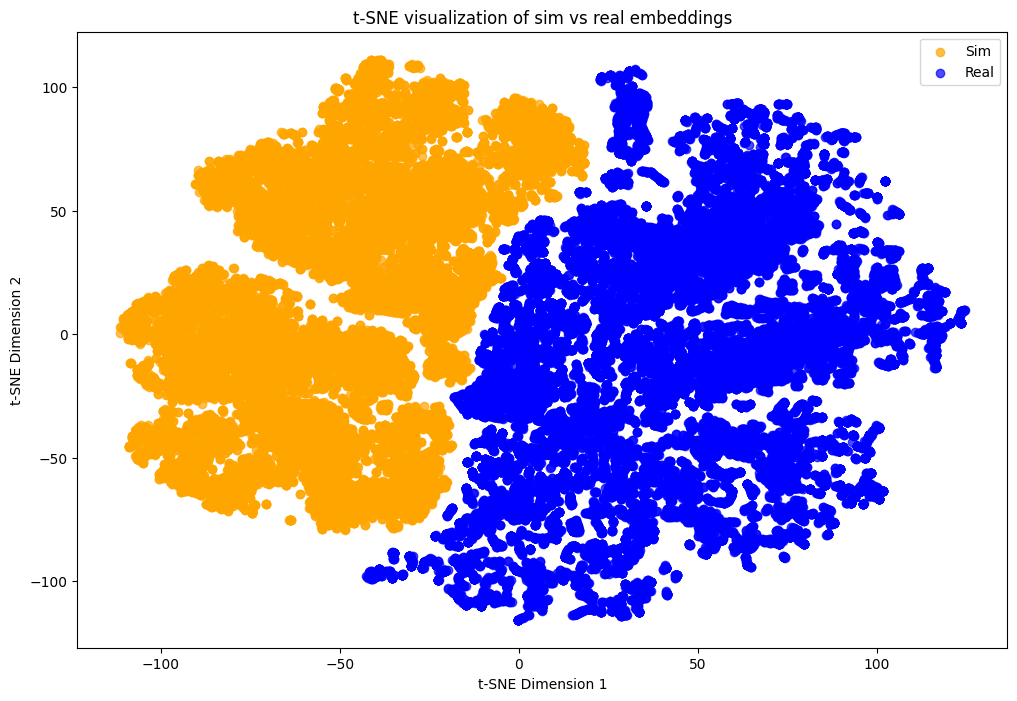

In [7]:
from src.models.tsne import plot_tsne

file_path = "/home/ubuntu/semrep/embeddings/encoders/dinov2.npz" 

dataset = np.load(file_path)
embeddings = dataset["embeddings"]
domain_labels = dataset["dataset_flag"]

# Plot t-SNE
plot_tsne(embeddings, domain_labels)

**IMAGE FINDER AND Grad-CAM**

Nearest indices: [ 25 307 756 677 284]
Labels of nearest points: [0. 0. 0. 0. 0.]
Furthest indices: [1253 1991 1410 1333 1499]
Labels of furthest points: [1. 1. 1. 1. 1.]


TypeError: 'Tensor' object is not callable

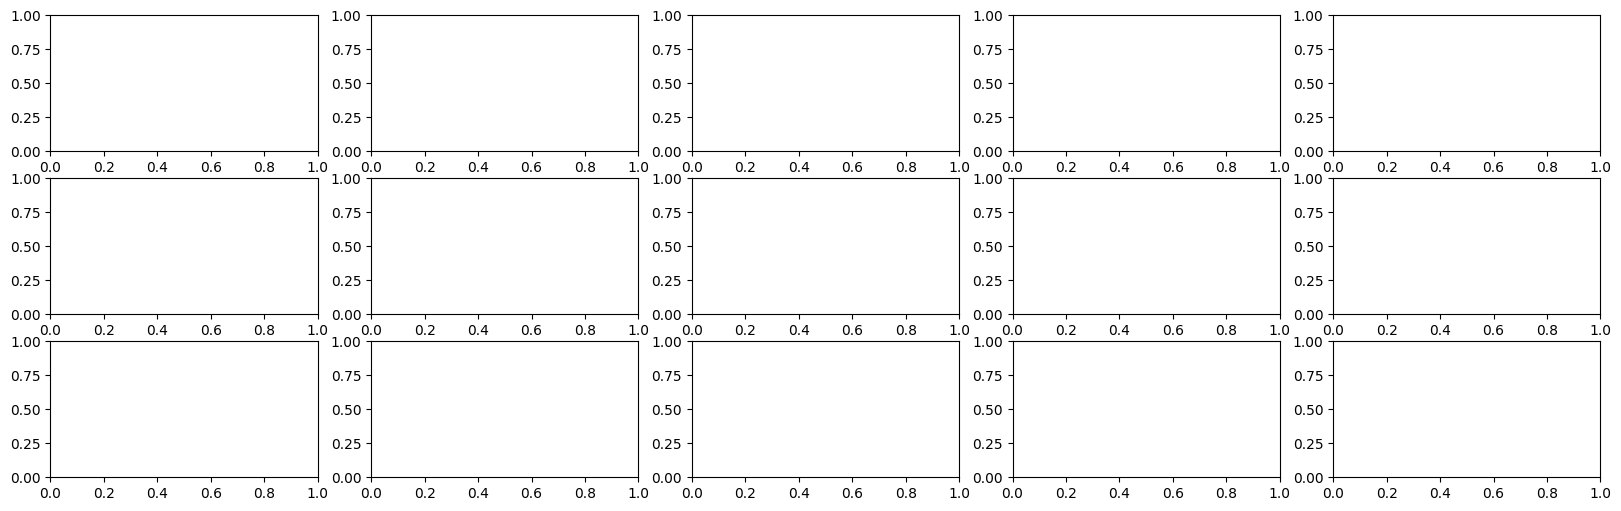

In [ ]:
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms import Normalize
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

model = model
model.eval()

target_layer = model.layer4[-1]

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())

# Select one image from the sim1 dataset
image_index = 0  # You can change this to select different images
input_image = sim1_images[image_index]

# Preprocess the image (assuming normalization is needed for the encoder)
# Define your normalization parameters based on how the model was trained
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
preprocessed_img = preprocess_image(input_image.cpu().numpy(), mean=mean, std=std)

target_class = 0
grayscale_cam = cam(input_tensor=preprocessed_img, targets=[ClassifierOutputTarget(target_class)])

input_image_np = input_image.cpu().numpy().transpose(1, 2, 0)
input_image_np = (input_image_np - np.min(input_image_np)) / (
    np.max(input_image_np) - np.min(input_image_np)
)


heatmap_image = show_cam_on_image(input_image_np, grayscale_cam, use_rgb=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image_np)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(heatmap_image)
plt.title("Grad-CAM Heatmap")
plt.show()

**Domain Probing**

In [5]:
from src.models.domainprobe import train_domain_probe
file_path = "/home/ubuntu/semrep/embeddings/encoders/dinov2.npz" 


train_domain_probe(file_path, epochs=30, batch_size=200, lr=0.001)


TypeError: can't convert np.ndarray of type numpy.str_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

**Domain Labels Alternative**

In [5]:
from src.models.domain_labels_r2 import domain_r_squared
from src.models.loadsplit import load_and_use_existing_split

file_path = "/home/ubuntu/semrep/embeddings/encoders/dinov2.npz" 


train_data, val_data = load_and_use_existing_split(file_path)

dataset = np.load(file_path)
embeddings = dataset["embeddings"]

domain_r_squared(embeddings, dataset["dataset_flag"])


9266304
R^2 value: 0.5447772436828339
